# Adding H&E information

In case you have an H&E slide aligned with your Spatial Transcriptomics data, you can train a new `Novae` model in multimodal mode.

To handle Spatial Transcriptomics combined with H&E data, `novae` uses [`sopa`](https://gustaveroussy.github.io/sopa/) and [`spatialdata`](https://spatialdata.scverse.org/en/latest/) as a backend.
To use these libraries, install `novae` with the `multimodal` extra, for instance:

```sh
# just the multimodal extra
pip install 'novae[multimodal]'

# with the CONCH extra, if you want CONCH embeddings
pip install 'novae[multimodal,conch]'
```


In [ ]:
import sopa

import novae

## Create a SpatialData object

You can open the data of one sample with one of the readers from [`sopa.io`](https://gustaveroussy.github.io/sopa/api/readers/).

If you don't have your own data, you can also download [this Xenium sample from 10X Genomics](https://www.10xgenomics.com/datasets/xenium-human-lung-cancer-post-xenium-technote) (in the "Output" panel, select "Xenium Prime 5K").
You can also directly download this sample via the command line as shown in [this script](https://github.com/MICS-Lab/novae/blob/main/docs/tutorials/download_xenium_sample.sh). You can also use `sdata = sopa.io.toy_dataset(as_output=True, genes=500)` for testing purposes.

> Note: you can also remove the `cells_table` and `cells_boundaries` argument, and re-run cell segmentation with [Sopa](https://gustaveroussy.github.io/sopa/).


In [ ]:
# if you want to run cell segmentation with Sopa, remove cells_table and cells_boundaries
sdata = sopa.io.xenium("Xenium_Prime_Human_Lung_Cancer_FFPE_outs", cells_table=True, cells_boundaries=True)

You see that you have your Xenium image, an H&E image, cell boundaries with the corresponding cell-by-gene table, and transcripts.

⚠️ If you don't already have aligned H&E, see [this Sopa tutorial](https://gustaveroussy.github.io/sopa/tutorials/align/) to align it.


In [43]:
sdata

SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 43270, 26720), (3, 21635, 13360), (3, 10817, 6680), (3, 5408, 3340), (3, 2704, 1670)
│     └── 'morphology_focus': DataTree[cyx] (4, 37348, 54086), (4, 18674, 27043), (4, 9337, 13521), (4, 4668, 6760), (4, 2334, 3380)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (3D points)
├── Shapes
│     └── 'cell_boundaries': GeoDataFrame shape: (278328, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (278328, 5001)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), morphology_focus (Images), transcripts (Points), cell_boundaries (Shapes)

For efficiency, you can save your `SpatialData` object and re-open it. Future computations will be faster.


In [ ]:
import spatialdata

# save it as a zarr diectory
sdata.write("Xenium_Prime_Human_Lung_Cancer_FFPE_outs.zarr")

# and read it back
sdata = spatialdata.read_zarr("Xenium_Prime_Human_Lung_Cancer_FFPE_outs.zarr")

## Prepare the H&E embeddings


### 1. Computing patch embeddings

We can define patches and use a computer vision model to extract embeddings from each patch. Here, to make it faster, we only compute patches which touches at least one cell, which may considerably reduce the number of patches.

By default, we use CONCH, which requires the two following step:

1. If not done yet, install the CONCH extra with `pip install 'novae[multimodal,conch]'`
2. Log in Hugging Face and approve their License, see [here](https://huggingface.co/MahmoodLab/CONCH).

⚠️ You can use other models, see the [sopa documentation](https://gustaveroussy.github.io/sopa/api/patches/#sopa.patches.compute_embeddings) for more details.

This can be done via [`compute_histo_embeddings`](../../api/data/#novae.compute_histo_embeddings), as below. Note that we used `device="cuda"` to accelerate the embeddings computation.


In [ ]:
novae.compute_histo_embeddings(sdata, model="conch", device="cuda")

### 2. Assigning the embeddings to the cells

Now that we have one embedding per patch, we can compute a PCA of these embeddings add assign to each cell the embedding of the closest patch. This can be done via [`compute_histo_pca`](../../api/data/#novae.compute_histo_pca) as below.

> We will have one patch embedding per cell (multiple cells may share the same embedding). This embedding is an H&E representation of the cell neighborhood, not just the cell itself.

⚠️ If you have multiple slides, run the previous `compute_histo_embeddings` function for each `sdata` object/slide, but run the below `compute_histo_pca` function with all the slides to have a shared embedding. Just pass a list of `SpatialData` objects instead of one.


In [ ]:
novae.compute_histo_pca(sdata)

### (Optional) show the CONCH embeddings

The CONCH embeddings are added as an AnnData table to the `SpatialData` object. You can show any dimension of these embeddings spatially as below.

> These are the patch embeddings, not the embeddings per cell.


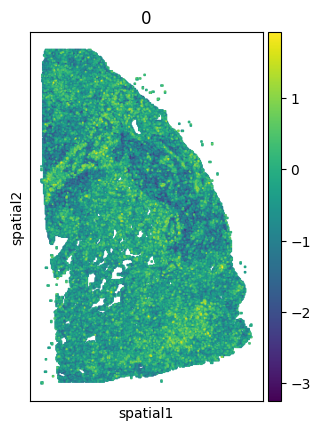

In [ ]:
import scanpy as sc

# dimension number 0 of the CONCH embeddings
sc.pl.spatial(sdata["conch_embeddings"], color="0", spot_size=10)

You can also show the same embeddings but once projected over the cells. It can be found inside the `table` AnnData object, under the `adata.obsm["histo_embeddings"]`.

> Note: the image show a different orientation, which is because the one above is shown on the H&E coordinate system, while the one below is using the micron coordinate system of the Xenium. Since we use `SpatialData`, we can transform any object to another coordinate systems if desired.


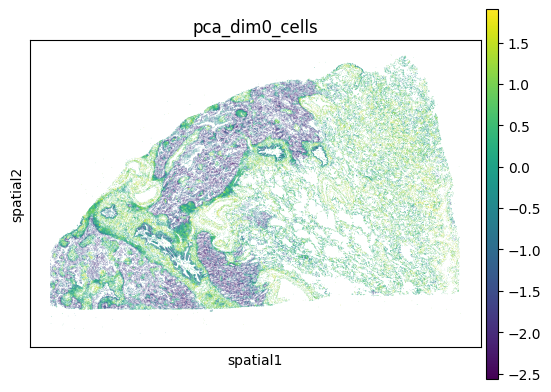

In [ ]:
adata = sdata["table"]

adata.obs["pca_dim0_cells"] = adata.obsm["histo_embeddings"][:, 0]

sc.pl.spatial(adata, color="pca_dim0_cells", spot_size=10)

## Training Novae

Now, we can go back to our cell-by-gene `AnnData` object. It's stored inside the `SpatialData` object:


In [62]:
adata = sdata["table"]

We see that we now have `histo_embeddings` in `adata.obsm`:


In [51]:
adata.obsm

AxisArrays with keys: intensities, spatial, histo_embeddings

As is the other tutorials, we compute the [`spatial_neighbors`](../../api/utils/#novae.spatial_neighbors):


In [64]:
novae.spatial_neighbors(adata, radius=80)  # try other radius if you see too many unconnected cells

[INFO] (novae.utils.build) Computing graph on 278,328 cells (coord_type=generic, delaunay=True, radius=[0.0, 80.0], n_neighs=None)


And we can check the connectivities, as in the other tutorials:


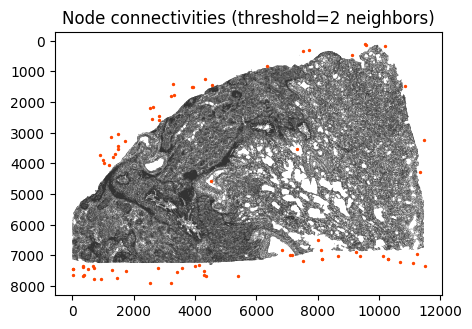

In [65]:
novae.plot.connectivities(adata)

You can then create a new Novae model.

> Note: By default it will initialize the gene embeddings via a PCA. You can also provide a `scgpt_model_dir` (see the docs [here](../../api/Novae/#novae.Novae.__init__)) to replace the PCA.

> Note 2: You can also fine-tune a pretrained model as in the other tutorials. It will automatically detect it has to use the multimodal mode, but this has not been extensively tested.


In [54]:
model = novae.Novae(adata)

[INFO] (novae.module.embed) Running PCA embedding initialization


Normally, showing the model now shows `Multimodal: True`. Note that `Trained: False` indicated the model is still not trained.


In [55]:
model

Novae model
   ├── Known genes: 250
   ├── Parameters: 523.4K
   ├── Model name: None
   ├── Trained: False
   └── Multimodal: True

Then, you can [`fit`](../../api/Novae/#novae.Novae.fit) the Novae model. Here, we used a `cuda` to accelerate the training (recommanded).

> Note: we also decreased the learning rate and increased the total number of epochs allowed. This is optional, you can also keep the default parameters (it would be faster).


In [ ]:
model.fit(adata, accelerator="cuda", num_workers=4, lr=2e-4, max_epochs=40)

The other steps are the same as in the other tutorials. I.e., we first compute the representations (here we use `cuda` again).


In [ ]:
model.compute_representations(adata, accelerator="cuda", num_workers=4)

Then assign the domains to the cells:


In [58]:
model.assign_domains(adata, level=8)

'novae_domains_8'

And, finally, we plot the spatial domains:


[INFO] (novae.utils._validate) Using obs_key='novae_domains_8' by default.


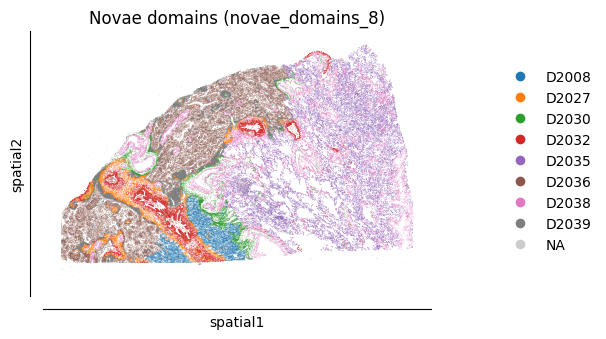

In [78]:
novae.plot.domains(adata)